# Connect to Snowflake

In [31]:
# access data from snowflake
import pandas as pd
from snowflake.snowpark.session import Session
from snowflake.snowpark.functions import *
from snowflake.snowpark.types import *

connection_parameters = {
    "account": "SN00102",
    "user": "", 
    "host": "sn00102.central-us.azure.snowflakecomputing.com",
    "password": "",
    "role": "ACCOUNTADMIN",
    "warehouse": "SMALL_WH",
    "database":"MFR",
    "schema":"PUBLIC"
    }
session = Session.builder.configs(connection_parameters).create()

maintenance_df = session.table('MFR.PUBLIC.maintenance')
humidity_df = session.table('MFR.PUBLIC.Humidity')
hum_udi_df = session.table('MFR.PUBLIC.HUMIDITY_UDI')

# Look at Each of the dataframes

In [32]:
maintenance_df.to_pandas().head()

,UDI,PRODUCT_ID,TYPE,AIR_TEMPERATURE_K,PROCESS_TEMPERATURE,ROTATIONAL_SPEED_RPM,TORQUE_NM,TOOL_WEAR_MIN,MACHINE_FAILURE,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298,309,1551,43,0,0,0,0,0,0,0
1,2,L47181,L,298,309,1408,46,3,0,0,0,0,0,0
2,3,L47182,L,298,309,1498,49,5,0,0,0,0,0,0
3,4,L47183,L,298,309,1433,40,7,0,0,0,0,0,0
4,5,L47184,L,298,309,1408,40,9,0,0,0,0,0,0


In [3]:
humidity_df.to_pandas().head()

,CITY_NAME,HUMIDITY_RELATIVE_AVG
0,Riyadh,71
1,Singapore,78
2,Los Angeles,63
3,Sydney,78
4,Kabul,57


In [4]:
hum_udi_df.to_pandas().head()

,UDI,CITY
0,1,Santiago
1,2,Dakar
2,3,Dhaka
3,4,Los Angeles
4,5,Baghdad


In [5]:
# join together the dataframes and prepare training dataset
maintenance_city = maintenance_df.join(hum_udi_df, ["UDI"])
maintenance_hum = maintenance_city.join(humidity_df, (maintenance_city.col("CITY") == humidity_df.col("CITY_NAME"))).select(col("TYPE"), 
col("AIR_TEMPERATURE_K"), col("PROCESS_TEMPERATURE"), col("ROTATIONAL_SPEED_RPM"), col("TORQUE_NM"), col("TOOL_WEAR_MIN"), col("HUMIDITY_RELATIVE_AVG"), col("MACHINE_FAILURE"))

In [6]:
# write training set to snowflake and materialize the data frame into a pandas data frame
maintenance_hum.write.mode("overwrite").save_as_table("MFR.PUBLIC.MAINTENANCE_HUM")
maintenance_hum_df = session.table('MFR.PUBLIC.MAINTENANCE_HUM').to_pandas()

In [7]:
# convert categorical to dummies
from pandas import get_dummies
# maintenance_hum_df = pd.concat([get_dummies(maintenance_hum_df[["TYPE"]]),maintenance_hum_df.drop(columns=["TYPE"])], axis = 1)
maintenance_hum_df = maintenance_hum_df.drop(columns=["TYPE"])

# Use MLFlow to track jobs and models

In [8]:
import mlflow
mlflow.set_experiment(experiment_name="predictive-maintenance2")


Bad pipe message: %s [b'\x03\x00\n\x00\x15\x00\x12\x00\x0f\x00\x0c\x00']
Bad pipe message: %s [b'\t\x00\x14\x00\x11\x00\x19\x00\x08\x00\x06\x00\x17\x00\x03\xc0\x10\xc0\x06\xc0\x15\xc0\x0b\xc0\x01']
Bad pipe message: %s [b'\xc2Bq\x92\xed\xf5\xb3W\xc3 Sa\xbc\x92\x06\xc5\xea2\x00\x00\xa2\xc0\x14\xc0\n\x009\x008\x007\x006\x00\x88\x00\x87\x00\x86\x00\x85\xc0\x19\x00:\x00\x89\xc0\x0f\xc0\x05\x005']
Bad pipe message: %s [b"Q}\x13QH\xd6\x16#Uk\xaa\xf9\xf3\x11\xc8\xf9\xc7E\x00\x00\x86\xc00\xc0,\xc0(\xc0$\xc0\x14\xc0\n\x00\xa5\x00\xa3\x00\xa1\x00\x9f\x00k\x00j\x00i\x00h\x009\x008\x007\x006\xc02\xc0.\xc0*\xc0&\xc0\x0f\xc0\x05\x00\x9d\x00=\x005\xc0/\xc0+\xc0'\xc0#\xc0\x13\xc0\t\x00\xa4\x00\xa2\x00\xa0\x00\x9e\x00g\x00@\x00?\x00>\x003\x002\x001\x000\xc01\xc0-\xc0)\xc0%\xc0\x0e\xc0\x04\x00\x9c\x00<\x00/\x00\x9a\x00\x99\x00\x98\x00\x97\x00\x96\x00\x07\xc0\x11\xc0\x07\xc0\x0c\xc0\x02\x00\x05\x00\x04\x00\xff\x02\x01\x00\x00g\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x0

<Experiment: artifact_location='', experiment_id='4f34f474-7a54-4263-9f6c-c4d7da4c3073', lifecycle_stage='active', name='predictive-maintenance2', tags={}>

# Split data and train model

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    maintenance_hum_df.drop("MACHINE_FAILURE", axis=1), maintenance_hum_df["MACHINE_FAILURE"], test_size=0.3
)

In [10]:
from sklearn.ensemble import RandomForestClassifier
mlflow.autolog()
model = RandomForestClassifier()


2023/03/16 13:44:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/03/16 13:44:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2023/03/16 13:44:11 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.
2023/03/16 13:44:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.


In [11]:
run = mlflow.start_run()

In [12]:
model.fit(X_train, y_train)

2023/03/16 13:44:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/anaconda/envs/azureml_py38/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
y_pred = model.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score, recall_score

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

2023/03/16 13:44:26 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.8a16cc55-2cfe-44a6-a0d2-5b9be3628917/metric_info.json already exists.


In [15]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))

Accuracy: 88.37%
Recall: 28.68%


In [16]:
mlflow.end_run()

In [17]:
run = mlflow.get_run(run.info.run_id)

# Look at model metrics

In [18]:
pd.DataFrame(data=[run.data.params], index=["Value"]).T

,Value
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_impurity_split,None


In [19]:
pd.DataFrame(data=[run.data.metrics], index=["Value"]).T

,Value
training_recall_score,0.999857
training_precision_score,0.999857
training_accuracy_score,0.999857
training_log_loss,0.067328
training_f1_score,0.999857
training_score,0.999857
accuracy_score_X_test,0.883667
recall_score_X_test,0.286802


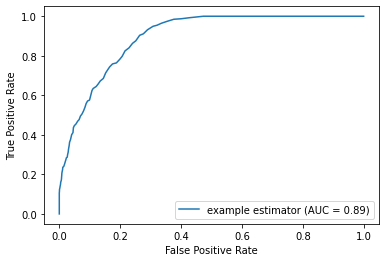

In [20]:
# evaluate model on test
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
y_pred = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                   estimator_name='example estimator')
display.plot()
plt.show()

In [21]:
# auc score
roc_auc_score(y_test, y_pred)

0.8944153671145463

2023/03/16 13:45:12 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: UserError: Resource Conflict: ArtifactId ExperimentRun/dcid.8a16cc55-2cfe-44a6-a0d2-5b9be3628917/metric_info.json already exists.


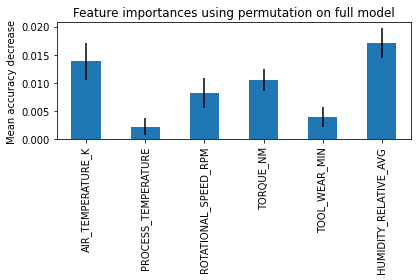

In [22]:
from sklearn.inspection import permutation_importance
feature_names = ['AIR_TEMPERATURE_K',
       'PROCESS_TEMPERATURE', 'ROTATIONAL_SPEED_RPM', 'TORQUE_NM',
       'TOOL_WEAR_MIN', 'HUMIDITY_RELATIVE_AVG']
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Register training dataset with mlflow runid

In [23]:
# register dataset
from azureml.core import Workspace, Dataset

# Connect to the Workspace
ws = Workspace.from_config()

# The default datastore is a blob storage container where datasets are stored
datastore = ws.get_default_datastore()

# Register the dataset
ds = Dataset.Tabular.register_pandas_dataframe(
        dataframe=maintenance_hum_df, 
        name=run.info.run_id+'maintenance_hum_df', 
        description='maintenance df for model training',
        target=datastore
    )

Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to managed-dataset/d805132c-a6b2-48f0-8a0b-698c8ee546c8/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


In [24]:
client = mlflow.tracking.MlflowClient()
client.list_artifacts(run_id=run.info.run_id)

[<FileInfo: file_size=-1, is_dir=False, path='metric_info.json'>,
 <FileInfo: file_size=-1, is_dir=True, path='model'>,
 <FileInfo: file_size=-1, is_dir=False, path='training_confusion_matrix.png'>,
 <FileInfo: file_size=-1, is_dir=False, path='training_precision_recall_curve.png'>,
 <FileInfo: file_size=-1, is_dir=False, path='training_roc_curve.png'>]

# Register Model

In [26]:
import os
mlflow.sklearn.save_model(model, "./maint")
model_local_path = os.path.abspath("./maint")
mlflow.register_model(f"file://{model_local_path}", "maint-model")

Registered model 'maint-model' already exists. Creating a new version of this model...
2023/03/16 13:46:30 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: maint-model, version 4
Created version '4' of model 'maint-model'.


<ModelVersion: creation_timestamp=1678974390720, current_stage='None', description='', last_updated_timestamp=1678974390720, name='maint-model', run_id='', run_link='', source='azureml://artifacts/LocalUpload/230316T134629-41304548/maint', status='READY', status_message='', tags={}, user_id='', version='4'>

# Deploy Model to snowflake

In [27]:
# create stage
session.sql("CREATE OR REPLACE STAGE MFR.PUBLIC.maint_stage").collect()

[Row(status='Stage area MAINT_STAGE successfully created.')]

In [28]:
# push model to stage in snowflake
# Model.get_model_path(model_name = 'mfr_model', version = 1, _workspace= ws)
session.file.put('maint/model.pkl', "MFR.PUBLIC.maint_stage", auto_compress=False, overwrite=True)

[PutResult(source='model.pkl', target='model.pkl', source_size=10277477, target_size=10277488, source_compression='NONE', target_compression='NONE', status='UPLOADED', message='')]

In [29]:
sql_cmd = '''
create or replace function predict_failure(a int, b int,c int,d int, 
                                     e int, f int)
returns float
language python
runtime_version = 3.8
packages = ('scikit-learn', 'pandas')
handler = 'udf'
imports = ('@maint_stage/model.pkl')
as $$
import pandas
import sklearn
import sys
import pickle
from _snowflake import vectorized

IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
pipe_file = import_dir + 'model.pkl'
with open(pipe_file,'rb') as f:
         pred_model = pickle.load(f)
         
@vectorized(input=pandas.DataFrame)
def udf(df):
    return pred_model.predict_proba(df)[:,1]
$$;
'''

In [33]:
session.sql(sql_cmd).collect()

[Row(status='Function PREDICT_FAILURE successfully created.')]